<a href="https://colab.research.google.com/github/MohamedElashri/SUSY/blob/add-docker-lock/SUSY_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SUSY Neural Networks

We use Deep Neural Networks to classify the supersymmetry dataset

In [4]:
#Import packages to use

from __future__ import print_function, division
import os,sys
import numpy as np
import torch
import warnings

seed=10
np.random.seed(seed)
torch.manual_seed(seed)


In [5]:
# supress the warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [3]:
# Download and extract the data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz
!gunzip -k SUSY.csv.gz


--2021-03-02 17:35:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/00279/SUSY.csv.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 922377711 (880M) [application/x-httpd-php]
Saving to: ‘SUSY.csv.gz.1’

SUSY.csv.gz.1       100%[===================>] 879.65M  54.7MB/s    in 17s     

2021-03-02 17:35:32 (53.0 MB/s) - ‘SUSY.csv.gz.1’ saved [922377711/922377711]

gzip: SUSY.csv already exists; do you wish to overwrite (y or n)? y


In [7]:
from torchvision import datasets # load data

class SUSY_Dataset(torch.utils.data.Dataset):
    """SUSY pytorch dataset."""

    def __init__(self, data_file, root_dir, dataset_size, train=True, transform=None, high_level_feats=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            train (bool, optional): If set to `True` load training data.
            transform (callable, optional): Optional transform to be applied on a sample.
            high_level_festures (bool, optional): If set to `True`, working with high-level features only. 
                                        If set to `False`, working with low-level features only.
                                        Default is `None`: working with all features
        """

        import pandas as pd

        features=['SUSY','lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi', 'MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2', 
                'S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']

        low_features=['lepton 1 pT', 'lepton 1 eta', 'lepton 1 phi', 'lepton 2 pT', 'lepton 2 eta', 'lepton 2 phi', 
                'missing energy magnitude', 'missing energy phi']

        high_features=['MET_rel', 'axial MET', 'M_R', 'M_TR_2', 'R', 'MT2','S_R', 'M_Delta_R', 'dPhi_r_b', 'cos(theta_r1)']


        #Number of datapoints to work with
        df = pd.read_csv('SUSY.csv', header=None,nrows=dataset_size,engine='python')
        df.columns=features
        Y = df['SUSY']
        X = df[[col for col in df.columns if col!="SUSY"]]

        # set training and test data size
        train_size=int(0.8*dataset_size)
        self.train=train

        if self.train:
            X=X[:train_size]
            Y=Y[:train_size]
            print("Training on {} examples".format(train_size))
        else:
            X=X[train_size:]
            Y=Y[train_size:]
            print("Testing on {} examples".format(dataset_size-train_size))


        self.root_dir = root_dir
        self.transform = transform

        # make datasets using only the 8 low-level features and 10 high-level features
        if high_level_feats is None:
            self.data=(X.values.astype(np.float32),Y.values.astype(int))
            print("Using both high and low level features")
        elif high_level_feats is True:
            self.data=(X[high_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both high-level features only.")
        elif high_level_feats is False:
            self.data=(X[low_features].values.astype(np.float32),Y.values.astype(int))
            print("Using both low-level features only.")


    # override __len__ and __getitem__ of the Dataset() class

    def __len__(self):
        return len(self.data[1])

    def __getitem__(self, idx):

        sample=(self.data[0][idx,...],self.data[1][idx])

        if self.transform:
            sample=self.transform(sample)

        return sample


In [8]:
def load_data(args):

    data_file='SUSY.csv'
    root_dir='SUSY_data'

    kwargs = {} # CUDA arguments, if enabled
    # load and noralise train and test data
    train_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=True,high_level_feats=args.high_level_feats),
        batch_size=args.batch_size, shuffle=True, **kwargs)

    test_loader = torch.utils.data.DataLoader(
        SUSY_Dataset(data_file,root_dir,args.dataset_size,train=False,high_level_feats=args.high_level_feats),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    return train_loader, test_loader


In [9]:
import torch.nn as nn # construct NN

class model(nn.Module):
    def __init__(self,high_level_feats=None):
        # inherit attributes and methods of nn.Module
        super(model, self).__init__()

        #y = Wx + b
        if high_level_feats is None:
            self.fc1 = nn.Linear(18, 200) # all features
        elif high_level_feats:
            self.fc1 = nn.Linear(10, 200) # low-level only
        else:
            self.fc1 = nn.Linear(8, 200) # high-level only


        self.batchnorm1=nn.BatchNorm1d(200, eps=1e-05, momentum=0.1)
        self.batchnorm2=nn.BatchNorm1d(100, eps=1e-05, momentum=0.1)

        self.fc2 = nn.Linear(200, 100) # see forward function for dimensions
        self.fc3 = nn.Linear(100, 2)

    def forward(self, x):
        '''Defines the feed-forward function for the NN.

        A backward function is automatically defined using `torch.autograd`

        Parameters
        ----------
        x : autograd.Tensor
            input data

        Returns
        -------
        autograd.Tensor
            output layer of NN

        '''

        # apply rectified linear unit
        x = F.relu(self.fc1(x))
        # apply dropout
        #x=self.batchnorm1(x)
        x = F.dropout(x, training=self.training)


        # apply rectified linear unit
        x = F.relu(self.fc2(x))
        
      
        x = F.dropout(x, training=self.training)


        # apply affine operation fc2
        x = self.fc3(x)
        # soft-max layer
        x = F.log_softmax(x,dim=1)

        return x


In [10]:
import torch.nn.functional as F 
import torch.optim as optim 

def evaluate_model(args,train_loader,test_loader):

    # create model
    DNN = model(high_level_feats=args.high_level_feats)
    # negative log-likelihood (nll) loss for training: takes class labels NOT one-hot vectors!
    criterion = F.nll_loss
    # define SGD optimizer
    optimizer = optim.SGD(DNN.parameters(), lr=args.lr, momentum=args.momentum)
  


    ################################################

    def train(epoch):
        '''Trains a NN using minibatches.

        Parameters
        ----------
        epoch : int
            Training epoch number.

        '''

        # set model to training mode (affects Dropout and BatchNorm)
        DNN.train()
        # loop over training data
        for batch_idx, (data, label) in enumerate(train_loader):
            # zero gradient buffers
            optimizer.zero_grad()
            # compute output of final layer: forward step
            output = DNN(data)
            # compute loss
            loss = criterion(output, label)
            # run backprop: backward step
            loss.backward()
            # update weigths of NN
            optimizer.step()
            
            # print loss at current epoch
            if batch_idx % args.log_interval == 0:
                print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data), len(train_loader.dataset),
                    100. * batch_idx / len(train_loader), loss.item() ))
            

        return loss.item()

    ################################################

    def test():
        '''Tests NN performance.

        '''

        # evaluate model
        DNN.eval()

        test_loss = 0 # loss function on test data
        correct = 0 # number of correct predictions
        # loop over test data
        for data, label in test_loader:
            # compute model prediction softmax probability
            output = DNN(data)
            # compute test loss
            test_loss += criterion(output, label, size_average=False).item() # sum up batch loss
            # find most likely prediction
            pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability
            # update number of correct predictions
            correct += pred.eq(label.data.view_as(pred)).cpu().sum().item()

        # print test loss
        test_loss /= len(test_loader.dataset)
        
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
            test_loss, correct, len(test_loader.dataset),
            100. * correct / len(test_loader.dataset)))
        

        return test_loss, correct / len(test_loader.dataset)


    ################################################


    train_loss=np.zeros((args.epochs,))
    test_loss=np.zeros_like(train_loss)
    test_accuracy=np.zeros_like(train_loss)

    epochs=range(1, args.epochs + 1)
    for epoch in epochs:

        train_loss[epoch-1] = train(epoch)
        test_loss[epoch-1], test_accuracy[epoch-1] = test()



    return test_loss[-1], test_accuracy[-1]


In [18]:
def grid_search(args):


    # perform grid search over learnign rate and number of hidden neurons
    dataset_sizes=[500000] #np.logspace(2,5,4).astype('int')
    learning_rates=np.logspace(-5,-1,5)

    # pre-alocate data
    test_loss=np.zeros((len(dataset_sizes),len(learning_rates)),dtype=np.float64)
    test_accuracy=np.zeros_like(test_loss)

    # do grid search
    for i, dataset_size in enumerate(dataset_sizes):
        # upate data set size parameters
        args.dataset_size=dataset_size
        args.batch_size=int(0.01*dataset_size)

        # load data
        train_loader, test_loader = load_data(args)

        for j, lr in enumerate(learning_rates):
            # update learning rate
            args.lr=lr

            print("\n training DNN with %5d data points and SGD lr=%0.6f. \n" %(dataset_size,lr) )

            test_loss[i,j],test_accuracy[i,j] = evaluate_model(args,train_loader,test_loader)


    plot_data(learning_rates,dataset_sizes,test_accuracy)


In [19]:
import matplotlib.pyplot as plt

def plot_data(x,y,data):

    # plot results
    fontsize=16


    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(data, interpolation='nearest', vmin=0, vmax=1)
    
    cbar=fig.colorbar(cax)
    cbar.ax.set_ylabel('accuracy (%)',rotation=90,fontsize=fontsize)
    cbar.set_ticks([0,.2,.4,0.6,0.8,1.0])
    cbar.set_ticklabels(['0%','20%','40%','60%','80%','100%'])

    # put text on matrix elements
    for i, x_val in enumerate(np.arange(len(x))):
        for j, y_val in enumerate(np.arange(len(y))):
            c = "${0:.1f}\\%$".format( 100*data[j,i])  
            ax.text(x_val, y_val, c, va='center', ha='center')

    # convert axis vaues to to string labels
    x=[str(i) for i in x]
    y=[str(i) for i in y]


    ax.set_xticklabels(['']+x)
    ax.set_yticklabels(['']+y)

    ax.set_xlabel('$\\mathrm{learning\\ rate}$',fontsize=fontsize)
    ax.set_ylabel('$\\mathrm{hidden\\ neurons}$',fontsize=fontsize)

    plt.tight_layout()

    plt.show()


Training on 400000 examples
Using both high and low level features
Testing on 100000 examples
Using both high and low level features

 training DNN with 500000 data points and SGD lr=0.000010. 

Train Epoch: 1 [0/400000 (0%)]	Loss: 0.703069
Train Epoch: 1 [50000/400000 (12%)]	Loss: 0.702222
Train Epoch: 1 [100000/400000 (25%)]	Loss: 0.700723
Train Epoch: 1 [150000/400000 (38%)]	Loss: 0.699577
Train Epoch: 1 [200000/400000 (50%)]	Loss: 0.698001
Train Epoch: 1 [250000/400000 (62%)]	Loss: 0.707108
Train Epoch: 1 [300000/400000 (75%)]	Loss: 0.706040
Train Epoch: 1 [350000/400000 (88%)]	Loss: 0.700586


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Streaming output truncated to the last 5000 lines.
Train Epoch: 147 [0/400000 (0%)]	Loss: 0.483366
Train Epoch: 147 [50000/400000 (12%)]	Loss: 0.482398
Train Epoch: 147 [100000/400000 (25%)]	Loss: 0.481211
Train Epoch: 147 [150000/400000 (38%)]	Loss: 0.471657
Train Epoch: 147 [200000/400000 (50%)]	Loss: 0.484419
Train Epoch: 147 [250000/400000 (62%)]	Loss: 0.478341
Train Epoch: 147 [300000/400000 (75%)]	Loss: 0.473359
Train Epoch: 147 [350000/400000 (88%)]	Loss: 0.494187

Test set: Average loss: 0.4515, Accuracy: 79040/100000 (79.040%)

Train Epoch: 148 [0/400000 (0%)]	Loss: 0.495473
Train Epoch: 148 [50000/400000 (12%)]	Loss: 0.489883
Train Epoch: 148 [100000/400000 (25%)]	Loss: 0.487233
Train Epoch: 148 [150000/400000 (38%)]	Loss: 0.467354
Train Epoch: 148 [200000/400000 (50%)]	Loss: 0.482738
Train Epoch: 148 [250000/400000 (62%)]	Loss: 0.479851
Train Epoch: 148 [300000/400000 (75%)]	Loss: 0.481102
Train Epoch: 148 [350000/400000 (88%)]	Loss: 0.481667

Test set: Average loss: 0.4513,

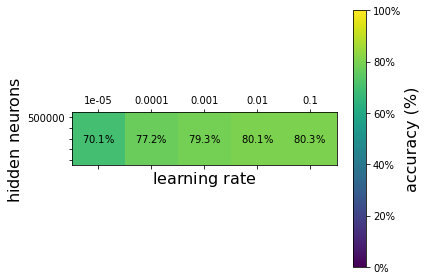

In [20]:
import argparse # handles arguments
import sys; sys.argv=['']; del sys # required to use parser in jupyter notebooks

# Training settings
parser = argparse.ArgumentParser(description='SUSY')
parser.add_argument('--dataset_size', type=int, default=500000, metavar='DS',
                help='size of data set (default: 100000)')
parser.add_argument('--high_level_feats', type=bool, default=None, metavar='HLF',
                help='toggles high level features (default: None)')
parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                help='input batch size for training (default: 64)')
parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
                help='input batch size for testing (default: 1000)')
parser.add_argument('--epochs', type=int, default=200, metavar='N',
                help='number of epochs to train (default: 10)')
parser.add_argument('--lr', type=float, default=0.05, metavar='LR',
                help='learning rate (default: 0.02)')
parser.add_argument('--momentum', type=float, default=0.8, metavar='M',
                help='SGD momentum (default: 0.5)')
parser.add_argument('--no-cuda', action='store_true', default=  True,
                help='disables CUDA training')
parser.add_argument('--seed', type=int, default=2, metavar='S',
                help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                help='how many batches to wait before logging training status')
args = parser.parse_args()

# set seed of random number generator
torch.manual_seed(args.seed)

grid_search(args)
